## Notebook 2: Create data sets from bounding boxes ##

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import tarfile
import random
import time
import glob
import json
import cv2
from pathlib import Path

# Matplotlib for plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import patches

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import dentexmodel as dm
from dentexmodel.fileutils import FileOP
from dentexmodel.imageproc import ImageData, crop_image

print(f'Project module version: {dm.__version__}')

Project module version: 0.0.post1.dev18+gbb11e12.d20231222


In [2]:
# Path settings 
dentex_dir = os.path.join(os.environ['HOME'], 'data', 'dentex')
data_dir = os.path.join(dentex_dir, 'dentex_disease')
Path(data_dir).mkdir(parents=True, exist_ok=True)
image_dir = os.path.join(data_dir, 'quadrant-enumeration-disease', 'xrays')
df_file_name = 'dentex_disease_dataset.parquet'
df_file = os.path.join(dentex_dir, df_file_name)
print(df_file)
print(image_dir)

/app/data/dentex/dentex_disease_dataset.parquet
/app/data/dentex/dentex_disease/quadrant-enumeration-disease/xrays


In [3]:
# Load the data frame with image paths and bounding boxes
an_df = pd.read_parquet(df_file)
display(an_df.head(2))
file_name_list = sorted(an_df['file_name'].unique())

,height,width,id,file_name,image_number,file_path,quadrant,position,label,area,bbox,box_name,annotations
0,1316,2744,1,train_673.png,673,/app/data/dentex/dentex_disease/quadrant-enume...,4,8,Impacted,39683,"[542.0, 698.0, 220.0, 271.0]",train_673_4_8,13
1,1316,2744,1,train_673.png,673,/app/data/dentex/dentex_disease/quadrant-enume...,4,1,Periapical Lesion,21469,"[1288.3116883116884, 723.3766233766233, 62.337...",train_673_4_1,13


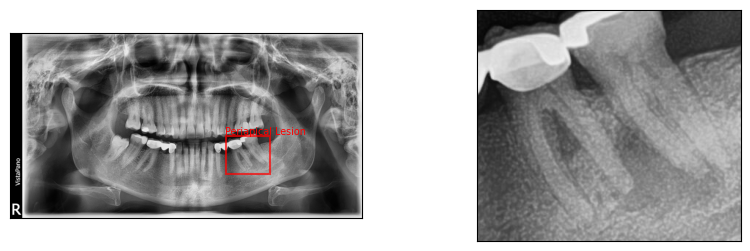

In [4]:
# Loop over the file names
f = 3
file_name = file_name_list[f]
box_name_list = an_df.loc[an_df['file_name'] == file_name, 'box_name'].values

# Loop over the bounding boxes for each file
b = 2
box_name = box_name_list[b]

# Get the row in the data frame
box_df = an_df.loc[(an_df['file_name'] == file_name) & (an_df['box_name'] == box_name)]
box = box_df['bbox'].values[0]
bbox = box[0], box[1], box[0] + box[2], box[1] + box[3]
label = box_df['label'].values[0]
file = os.path.join(image_dir, file_name)

# Load the image and then plot it with the bounding box
im = ImageData().load_image(file)
im_crop = crop_image(im, bbox)

# Show image with the box
text_offset_xy = (-10, -10)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
ax[0].imshow(im)
ax[1].imshow(im_crop)
rect = patches.Rectangle(xy=(box[0], box[1]), width=box[2], height=box[3], 
                                 linewidth=1.5, edgecolor='r', 
                                 facecolor='none', alpha=0.7)
ax[0].add_patch(rect)
ax[0].text(box[0]+text_offset_xy[0], box[1]+text_offset_xy[1], label, color='r', fontsize='x-small')
for axa in ax:
    axa.set(xticks=[], yticks=[])
plt.show()

In [5]:
# File path for the cropped images
cropped_image_dir = os.path.join(image_dir, 'crop')
Path(cropped_image_dir).mkdir(exist_ok=True)
file_name_list = sorted(an_df['file_name'].unique())

# Start a list of new data frames
data_df_list = []

# Loop over the panoramic x-rays
for f, file_name in enumerate(file_name_list):
    box_name_list = an_df.loc[an_df['file_name'] == file_name, 'box_name'].values
    if (f + 1) % 50 == 0:
        print(f'Processing image {f+1} / {len(file_name_list)}')
    # Loop over the bounding boxes for this file
    for b, box_name in enumerate(box_name_list):
        box_file = os.path.join(cropped_image_dir, f'{box_name}.png')
        
        # Get the row in the data frame
        box_df = an_df.loc[(an_df['file_name'] == file_name) & (an_df['box_name'] == box_name)].\
                        assign(box_file=box_file)
        box = box_df['bbox'].values[0]
        bbox = box[0], box[1], box[0] + box[2], box[1] + box[3]
        label = box_df['label'].values[0]
        file = os.path.join(image_dir, file_name)

        if not os.path.exists(box_file):
            
            # Load the image and then crop it
            im = ImageData().load_image(file)
            im_crop = crop_image(im, bbox)
                
            # Some contrast enhancement
            im_crop_enhanced = ImageData().hist_eq(im_crop)
            
            # Save the image
            cv2.imwrite(box_file, cv2.cvtColor(im_crop_enhanced, cv2.COLOR_RGB2BGR))

        # Add the image size to the data frame
        box_file_size = ImageData().image_size(box_file)
        box_df = box_df.assign(im_width=box_file_size[1],
                               im_height=box_file_size[0])
        
        # Add the data frame for this image to the list
        data_df_list.append(box_df)

# Concatenate the data frames
data_df = pd.concat(data_df_list, axis=0, ignore_index=True)

Processing image 50 / 678
Processing image 100 / 678
Processing image 150 / 678
Processing image 200 / 678
Processing image 250 / 678
Processing image 300 / 678
Processing image 350 / 678
Processing image 400 / 678
Processing image 450 / 678
Processing image 500 / 678
Processing image 550 / 678
Processing image 600 / 678
Processing image 650 / 678


In [6]:
# Save the data frame
df_box_file = df_file.replace('dataset', 'cropped_dataset')
data_df.to_parquet(df_box_file)

In [7]:
display(data_df.head())

,height,width,id,file_name,image_number,file_path,quadrant,position,label,area,bbox,box_name,annotations,box_file,im_width,im_height
0,1316,2850,57,train_0.png,0,/app/data/dentex/dentex_disease/quadrant-enume...,2,6,Caries,33015,"[1791.0, 445.72727272727263, 147.4545454545452...",train_0_2_6,2,/app/data/dentex/dentex_disease/quadrant-enume...,147,323
1,1316,2850,57,train_0.png,0,/app/data/dentex/dentex_disease/quadrant-enume...,4,8,Caries,35006,"[682.090909090909, 687.5454545454545, 200.0, 3...",train_0_4_8,2,/app/data/dentex/dentex_disease/quadrant-enume...,200,300
2,1316,2750,442,train_1.png,1,/app/data/dentex/dentex_disease/quadrant-enume...,4,8,Impacted,36765,"[729.6296296296296, 713.5802469135803, 166.666...",train_1_4_8,2,/app/data/dentex/dentex_disease/quadrant-enume...,166,295
3,1316,2750,442,train_1.png,1,/app/data/dentex/dentex_disease/quadrant-enume...,3,8,Impacted,32013,"[1978.125, 723.9583333333334, 144.791666666666...",train_1_3_8,2,/app/data/dentex/dentex_disease/quadrant-enume...,145,301
4,1316,2837,198,train_10.png,10,/app/data/dentex/dentex_disease/quadrant-enume...,4,7,Caries,30598,"[702.0, 772.0, 194.0, 246.0]",train_10_4_7,5,/app/data/dentex/dentex_disease/quadrant-enume...,194,246
